# Programming Assignment # 2: Convolutional Neural Networks
## Baseline

## 1. Data Preparation

In [1]:
# collect the data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys ()

/home/ji.702/anaconda3/envs/sloan/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Get the features and labels
import numpy as np
X, y = mnist ["data"], mnist["target"]
y = y.astype(int)

X = ((X/255.) - .5)*2

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)
print(min(y), max(y))
print(type(X), type(y))

print(np.min(np.min(X)), np.max(np.max(X)))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


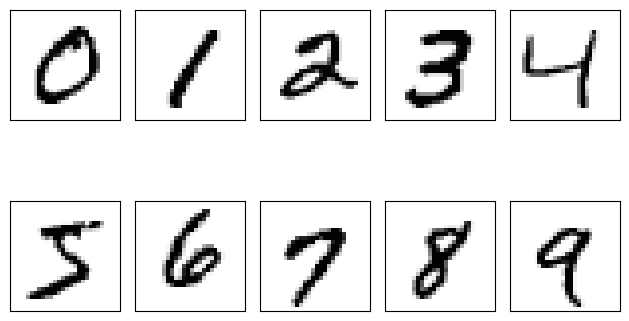

In [3]:
# Visualize the data
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range (10):
    matchlist = [i for i, x in enumerate(y == i) if x]
    img = X[matchlist[0]].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
# Data Splitting
# The first 60000 images are for training and the last 10000 images are for testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [5]:
# Further splits
# 54000 images are for training and the other 6000 images are for development sets
from sklearn.model_selection import StratifiedShuffleSplit
import collections

split = StratifiedShuffleSplit (n_splits = 1, test_size = 0.1, random_state = 42)
for train_index, val_index in split.split(X_train, y_train):
    X_train_strat = X[train_index,:]
    y_train_strat = y[train_index]

    X_dev_strat = X[val_index,:]
    y_dev_strat = y[val_index]

print (X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


## 2. CNN Design

In [6]:
# import key libraries
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix

In [7]:
# Define Hyper-parameters
class hyperparam:
    num_hid1_units = 60  # six 3*3 kernels: (3*3+1)*6
    num_hid2_units = 100  # ten 3*3 kernels: (3*3+1)*10
    num_classes = 10
    input_dim = 28*28

    lr = 0.05 # Learning rate
    momentum = 0.9 # momentum
    num_epochs = 100 # Number of epochs
    bs = 50 # mini-batch size

In [8]:
# Define Data Loader
class myDataset(data.Dataset):
    def __init__(self, input_data, labels, transform=None):
        # Initialize variables
        self.feats = input_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels) # return the number of samples
    
    def __getitem__(self, index):
        # Reshape image to 1x28x28 (1 channel, 28x28 pixels)
        X = self.feats[index].reshape(1, 28, 28)
        y = self.labels[index]

        # Apply transformations if any
        if self.transform:
            X = self.transform(X)

        return X, y

# Define transformations if needed (e.g., ToTensor)
# For the sake of simplicity, we'll convert arrays to tensors manually here. You can also use torchvision.transforms.
transform = lambda x: torch.tensor(x, dtype=torch.float)
   
params = {
    'batch_size': hyperparam.bs,
    'shuffle': True,
    'num_workers': 6,
    'drop_last': False,
    'pin_memory': True
} 
      
training_set = myDataset(X_train_strat, y_train_strat, transform=transform)
dev_set = myDataset (X_dev_strat, y_dev_strat, transform=transform)
test_set = myDataset (X_test, y_test, transform=transform)

training_gen = data.DataLoader(training_set, **params)
dev_gen = data.DataLoader(dev_set, **params)
testing_gen = data.DataLoader(test_set, **params)

In [53]:
# Define the Neural Network
class CNN(nn.Module):
    def __init__(self):
        super (CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)  # 1 input channel, 6 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(3, 1)  # Max pooling layer with 2x2 kernel and stride
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1) # 6 input channels, 10 output channels, 3x3 kernel

        # Calculate the size of the flattened features after convolutions and pooling
        # Assuming max pooling with a kernel of 3*3 is applied after each convolution
        # This calculation depends on the input dimensions and architecture specifics
        # For the MNIST dataset (28x28 images) and this architecture:
        self.num_flat_features = 10 * 20 * 20  #  Adjusted for 3x3 max pooling after each convolution

        # Fully connected layer for classification
        self.fc1 = nn.Linear(self.num_flat_features, 10)  # 10 output classes

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)

    def forward(self, x):
        # Apply first convolutional layer and ReLU activation,then max pooling
        x = self.pool(Func.relu(self.conv1(x)))
        # Apply second convolutional layer and ReLU activation
        x = self.pool(Func.relu(self.conv2(x)))

        # Flatten the output from convolutional layers to feed into the fully connected layer
        x = x.view(-1, self.num_flat_features)
        
        # Output layer
        x = self.fc1(x)

        return x

In [55]:
# Create DNN and define loss function
cnn_model = CNN()
loss = nn.CrossEntropyLoss()

print(cnn_model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4000, out_features=10, bias=True)
)


In [56]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.SGD(cnn_model.parameters() , lr=hyperparam.lr, momentum=hyperparam.momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Adjust LR by 10% every 10 epochs

optimizer, scheduler

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     initial_lr: 0.05
     lr: 0.05
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.StepLR at 0x7fc219cd7a90>)

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## 3. CNN Training

In [58]:
# Early stopping criteria initialization
best_loss = float('inf')  # Initialize best_loss to infinity
counter = 0  # Initialize counter to count epochs without improvement
stop_threshold = 5  # Define the early stopping patience

In [59]:
# Initialize the lists for tracking metrics
tr_avgLoss_list = []
tr_accuracy_list = []
dev_avgloss_list = []
dev_accuracy_list = []

In [60]:
# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    # Variables for training
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0

    # Variables for validation
    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0


    # Training
    cnn_model.train(True)

    
    for local_batch, local_labels in training_gen:

        # Transfer to device
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)

        # Forward pass
        out = cnn_model(local_batch)

        # Loss calculation
        loss_value = loss(out, local_labels.long())
        tr_total_loss += loss_value * hyperparam.bs

        # print(f"Training Loss: {tr_total_loss}")

        # Calculate accuracy
        pred_classes = torch.argmax(out, dim=1)
        tr_num_correct += torch.sum(pred_classes == local_labels).item()
        tr_num_samples += local_labels.size(0)  # Counting the batch size

        # Backpropagation
        optimizer.zero_grad()
        loss_value.backward() # gradient calculation
        optimizer.step() # weight update

    scheduler.step()

    # Calculate training accuracy and loss
    train_avg_loss = tr_total_loss / len(training_gen.dataset)
    train_accuracy = tr_num_correct / tr_num_samples
    tr_avgLoss_list.append(train_avg_loss.item())
    tr_accuracy_list.append(train_accuracy)

    # print(f"Training Avg Loss: {train_avg_loss}")

    # Validation
    cnn_model.eval()

    for local_batch, local_labels in dev_gen:
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)

        # Model computations
        out = cnn_model(local_batch)

        # CrossEntropy loss calculation
        loss_value = loss(out, local_labels.long())
        dev_total_loss += loss_value * hyperparam.bs  # Correct for average based on batch size

        # print(dev_total_loss)
        
        # Calculate accuracy
        pred_classes = torch.argmax(out, dim=1)
        dev_num_correct += torch.sum(pred_classes == local_labels).item()
        dev_num_samples += local_labels.size(0)  # Counting the batch size

     # Calculate validation accuracy and loss
    dev_avg_loss = dev_total_loss / len(dev_gen.dataset)
    dev_accuracy = dev_num_correct / dev_num_samples
    dev_avgloss_list.append(dev_avg_loss.item())
    dev_accuracy_list.append(dev_accuracy)

    # print(f"Validation Avg Loss: {dev_avg_loss}")

    # Early stopping check and model saving logic
    if dev_avg_loss < best_loss:
        print(f"New best validation loss: {dev_avg_loss}. Saving model...")
        best_loss = dev_avg_loss
        torch.save(cnn_model.state_dict(), 'path_to_save_model.pt')
        counter = 0  # Reset counter on improvement
    else:
        counter += 1  # Increment counter if no improvement
        if counter >= stop_threshold:
            print(f"Stopping early at epoch {epoch}")
            break  # Exit the loop if early stopping criteria are met


New best validation loss: 0.517542839050293. Saving model...
New best validation loss: 0.3329237997531891. Saving model...
New best validation loss: 0.3323615491390228. Saving model...
Stopping early at epoch 10


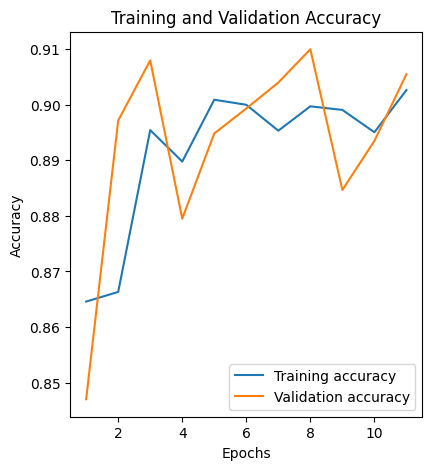

In [61]:
import matplotlib.pyplot as plt

# Plotting the learning curves
epochs = range(1, len(tr_avgLoss_list) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_accuracy_list, label='Training accuracy')
plt.plot(epochs, dev_accuracy_list, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


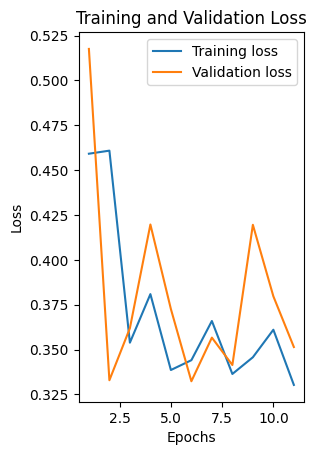

In [62]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_avgLoss_list, label='Training loss')
plt.plot(epochs, dev_avgloss_list, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Discussion
The addition of max pooling appears to bring the validation loss closer to the training loss, which is typically an indication of improved generalization.

In [63]:
# Testing
with torch.set_grad_enabled(False):
    cnn_model.eval()

    test_total_loss = 0.0
    test_num_samples = 0
    test_num_correct = 0

    pred = []
    y_testnew = []

    for local_batch, local_labels in testing_gen:
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)

        # Model computations
        out1 = cnn_model(local_batch)

        # CrossEntropy loss calculation
        pLoss = loss(out1, local_labels.long())
        test_total_loss += pLoss * len(local_labels)  # Correct for average based on batch size

        sel_class = torch.argmax(out1, dim=1)
        pred += sel_class.tolist()
        y_testnew += local_labels.tolist()

        test_num_correct += (sel_class == local_labels).sum().item()
        test_num_samples += len(local_labels)

    test_avgLoss = test_total_loss / len(testing_gen.dataset)
    test_accuracy = test_num_correct / test_num_samples

    print('Test Loss: {:.9f}, Test Accuracy: {:.5f}'.format(test_avgLoss, test_accuracy))

Test Loss: 0.318559885, Test Accuracy: 0.91160


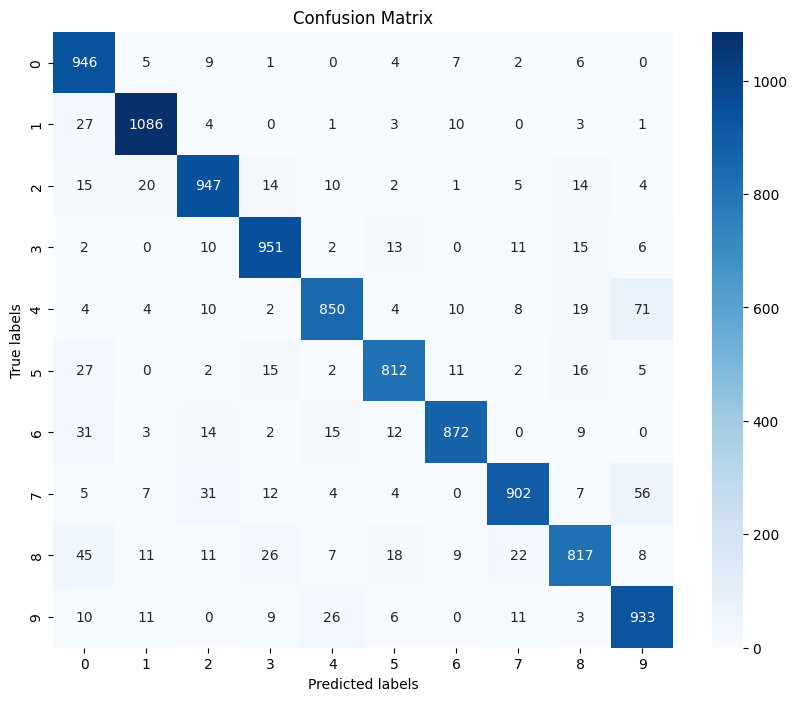

In [64]:
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_testnew, pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Discussion
The CNN without max pooling has a lower test loss compared to the CNN with max pooling. The accuracy of the CNN without max pooling is higher than the CNN with max pooling.

Max pooling is commonly used in CNNs to reduce the spatial dimensions of the feature maps, which can help in making the model more robust to variations in the input data and reduce computational complexity. However, the performance of max pooling also depends on the specific characteristics of the data and the task. In this case, the model without max pooling appears to outperform the model with max pooling, suggesting that for this particular task and dataset, the feature resolution preserved by not using max pooling is beneficial for the model's performance.